**Ashutosh Singh - 17CH30004**

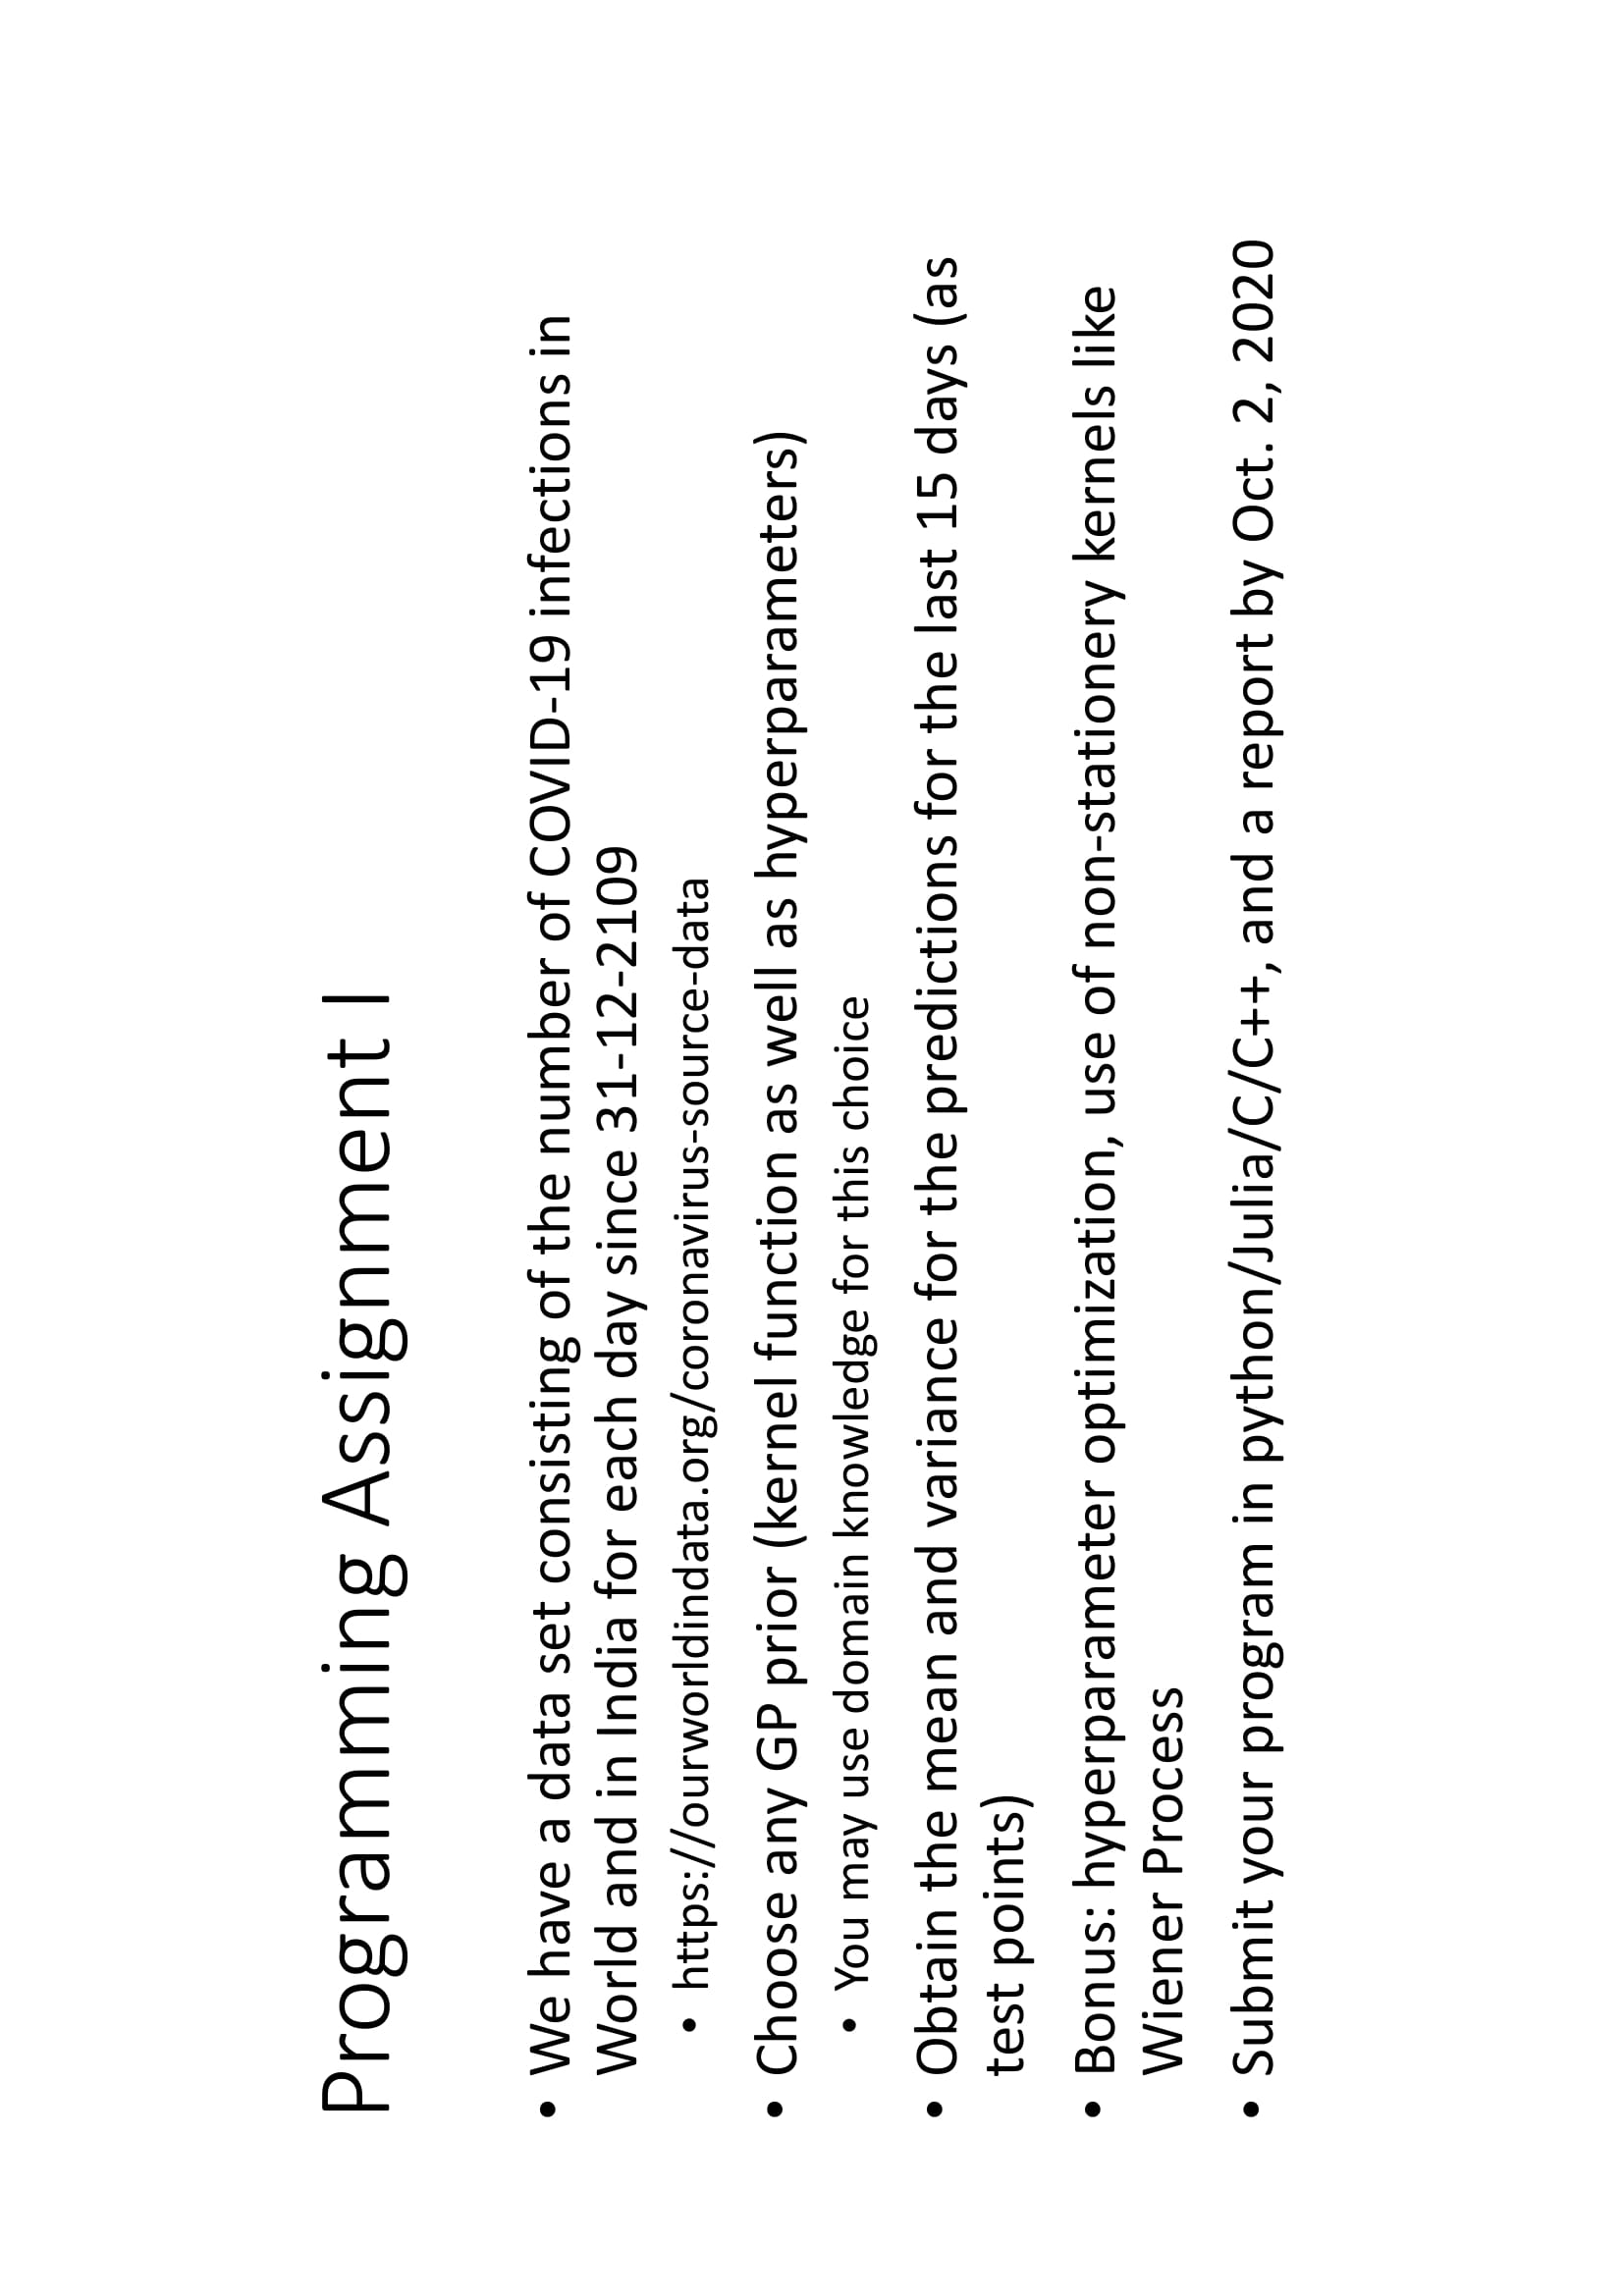

**Theory**

> In supervised learning, we often use parametric models p(y|X,θ) to explain data and infer optimal values of parameter θ via maximum likelihood or maximum a posteriori estimation. If needed we can also infer a full posterior distribution p(θ|X,y) instead of a point estimate θ^. 

With increasing data complexity, models with a higher number of parameters are usually needed to explain data reasonably well. Methods that use models with a fixed number of parameters are called parametric methods.

> Gaussian Process : It is a collection of Random Variables, any finite number of which have (consistent) Gaussian distributions.
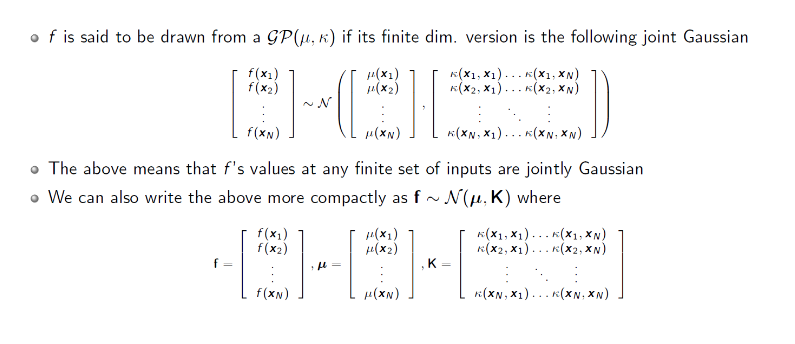


A Gaussian process is a random process where any point x∈Rd is assigned a random variable f(x) and where the joint distribution of a finite number of these variables p(f(x1),…,f(xN)) is itself Gaussian:
p(f|X)=N(f|μ,K)(1)

> **p(f | X) = N(f | μ, K)**         -------------------------------------------------         (1)


In Equation (1):

1.   f=(f(x1),…,f(xN)), μ=(m(x1),…,m(xN)) and Kij=κ(xi,xj).
2.   m is the mean function and it is common to use m(x)=0 as GPs are flexible enough to model the mean arbitrarily well.
3. κ is a positive definite kernel function or covariance function.
4. Thus, a Gaussian process is a distribution over functions whose shape (smoothness, …) is defined by K.






# **Approach and Code**



1.   We begin by import of various libraries and the upload of the data needed.



**Imports**

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("default")
%matplotlib inline

**Data Loading, Pre-Processing and Exploration**

In [198]:
df = pd.read_csv("/content/drive/My Drive/new_casesWorld-India.csv", index_col=None, parse_dates=['Date'])
df.head()

,Day,Date,World,India
0,1,2019-12-31,27,0
1,2,2020-01-01,0,0
2,3,2020-02-01,0,0
3,4,2020-03-01,17,0
4,5,2020-04-01,0,0


2. This block of code defines the statistical properties of the data that might help in deciding its kernel and hence prior.

In [199]:
df.describe()

,Day,World,India
count,266.000000,266.000000,266.000000
mean,133.500000,116885.221805,20630.000000
std,76.931788,102960.334640,29427.430481
min,1.000000,0.000000,0.000000
25%,67.250000,4134.250000,2.000000
50%,133.500000,88755.000000,3663.000000
75%,199.750000,211794.750000,34336.750000
max,266.000000,314666.000000,97894.000000


3. Here we are standardising and normalising the data to observe the variance on the graph better and bring the mean of the actual data close to zero so that our assumption of the prior mean function remains relevant.

In [200]:
#taking everything except the last 15 data points in the training set
trans_data= df[:-15]

#computing the mean and standard deviation for India and World Data 
mean_i = trans_data.India.mean()
std_i = trans_data.India.std()

mean_w = trans_data.World.mean()
std_w = trans_data.World.std()

#standardising the data by subtracting the mean and dividing the difference by the respective SDs
df['India_m'] = (df['India']-mean_i)/std_i
df['World_m'] = (df['World']-mean_w)/std_w

df

,Day,Date,World,India,India_m,World_m
0,1,2019-12-31,27,0,-0.671434,-1.098469
1,2,2020-01-01,0,0,-0.671434,-1.098746
2,3,2020-02-01,0,0,-0.671434,-1.098746
3,4,2020-03-01,17,0,-0.671434,-1.098571
4,5,2020-04-01,0,0,-0.671434,-1.098746
...,...,...,...,...,...,...
261,262,2020-09-17,291785,97894,3.338977,1.890255
262,263,2020-09-18,314666,96424,3.278756,2.124645
263,264,2020-09-19,309844,93337,3.152291,2.075249
264,265,2020-09-20,294862,92605,3.122303,1.921776


**Exploration**

1. Distribution Plots

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of COVID Cases in World')

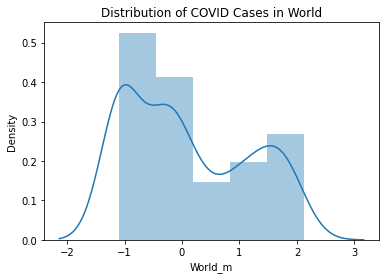

In [201]:
sns.distplot(df.World_m).set_title('Distribution of COVID Cases in World')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of COVID Cases in India')

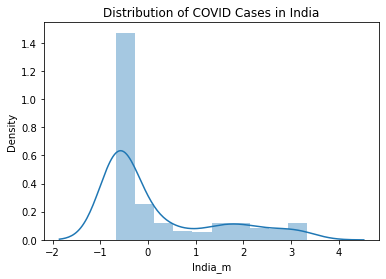

In [202]:
sns.distplot(df.India_m).set_title('Distribution of COVID Cases in India')

2. Scatter plot of the actual data

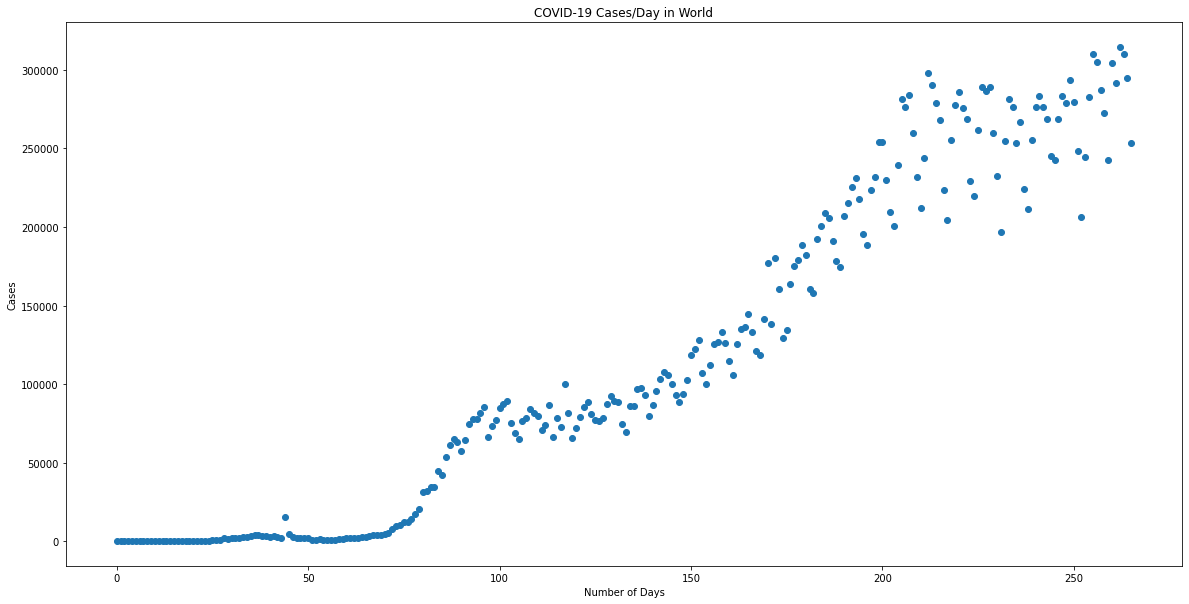

In [203]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('COVID-19 Cases/Day in World')
plt.xlabel('Number of Days')
plt.ylabel('Cases')
plt.scatter(df.index, df['World'])

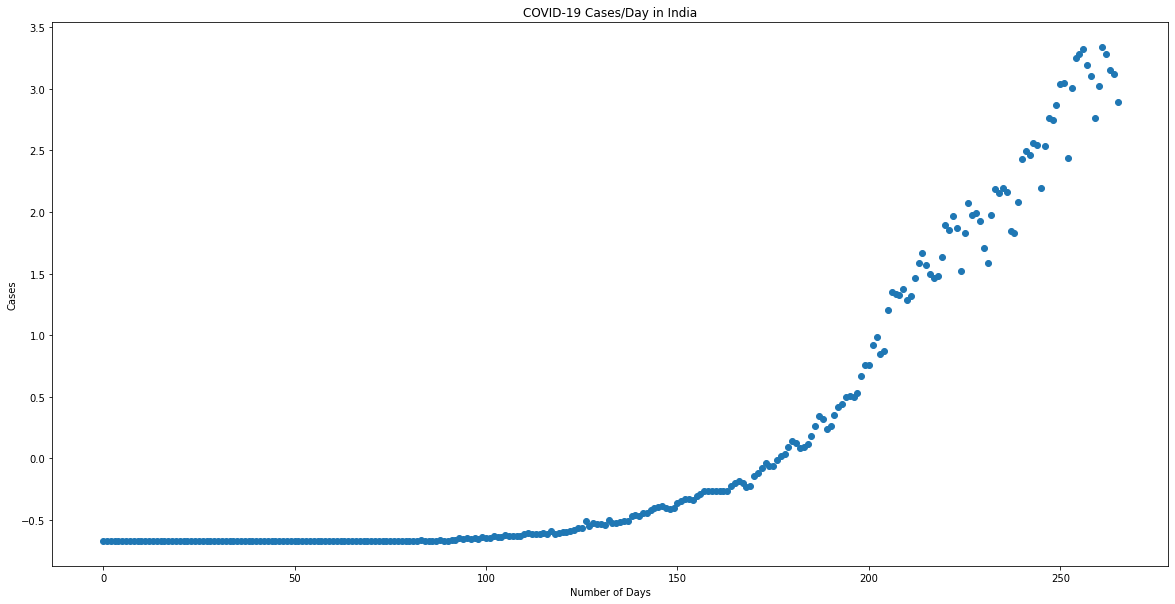

In [204]:
df.sort_values(by = 'Date', inplace = True)
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('COVID-19 Cases/Day in India')
plt.xlabel('Number of Days')
plt.ylabel('Cases')
plt.scatter(df.index, df['India_m'])

**Splits**

1.  Train
2.  Test (Last 15)



In [205]:
df.set_index('Day', inplace=True, drop=True)

In [206]:
df.sort_values(by = 'Day', inplace=True)
y_train_i = df[:-15].India_m.values.tolist()
y_test_i = df[-15:].India_m.values.tolist()
x_train_i = df[:-15].index.values.tolist()
x_test_i = df[-15:].index.values.tolist()

In [207]:
y_train_w = df[:-15].World_m.values.tolist()
y_test_w = df[-15:].World_m.values.tolist()

# **Function Definitions**

**Plot Function**

**Plotting the Gaussian Process**
1. Here I have taken a function to plot the GP from a blog of Martin Krasser and tweaked it a bit for my use case

In [208]:
def plot_gps(mu, covmat, X, X_train=None, Y_train=None, gt=None, samples=[]):
    
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covmat))
    
    fig, ax = plt.subplots(figsize=(20,10))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    plt.plot(X, mu, label='Mean')
    
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    
    if X_train is not None:
        plt.plot(X_train, Y_train, 'ro')
    if gt is not None:
      plt.scatter(X, gt, marker='x')
    plt.legend(bbox_to_anchor=(1.04,0.5),loc='center left')

**Kernel**

Here I have defined a Gaussian or Radial Basis Function Kernel.
1. The length parameter l controls the smoothness of the function
2. σf determines the vertical variation. 

For simplicity, we use the same length parameter l for all input dimensions (isotropic kernel).
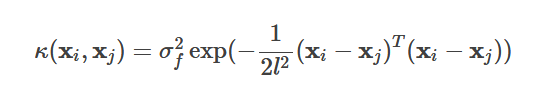

In [209]:
def kernel(X1, X2, l=5.0, s_f=1.0, ktype="rbf"):
  return s_f**2 * np.exp(-0.5 / l**2 * (np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)))

**Sufficient Statistics**

A GP prior **p(f|X)** can be converted into a GP posterior **p(f|X,y)** after having observed some data y. The posterior can then be used to make predictions f∗ given new input X∗

Here, I have defined a function that takes:
1. Xs (Newly Obs Data [in case of PPD] and Evidence in case of Posterior), 
2. X_train, Y_train
3. l = length parameter of the kernel
4. s_f = sigma of the kernel
5. s_y = noise

The function helps us to predict the new mean and covariance matrix for the posterior after it sees some present data y and modifies itself from a prior.

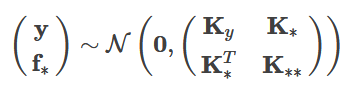

With N training data and N∗ new input data.

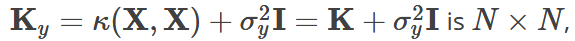

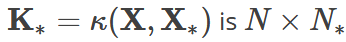

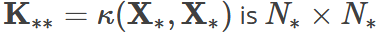

(σy)^2 is the noise term in the diagonal of Ky.

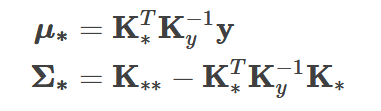

In [210]:
def sufficient_statistics(Xs, X, Y, l=1.0, s_f=1.0, s_y=1.0,prior="rbf"):
    Ky = kernel(X,X,l,s_f,ktype=prior) + s_y**2*np.eye(len(X))
    Ks = kernel(X,Xs, l, s_f,ktype=prior)
    Kss = kernel(Xs,Xs, l ,s_f,ktype=prior)+ 1e-5 * np.eye(len(Xs))

    # mean 
    mu = Ks.T.dot(np.linalg.inv(Ky)).dot(Y)
    # covariance 
    covmat = Kss - Ks.T.dot(np.linalg.inv(Ky)).dot(Ks)
    return mu, covmat

**Hyperparameter Optimization Function**

The goodness of fit depends heavily on the Kernel function. However, even more important is the right choice of hyperparameters, as the kernel functions themselves are indeed quite flexible. 

Optimising the log marginal likelihood.
The standard form of the log-likelihood function for a multivariate gaussian is as follows:

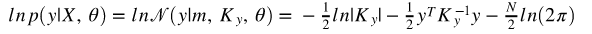

Finding the values for our hyperparameters that minimise this function is an optimisation problem, so we're gonna need its gradient:

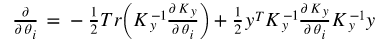

I have used the BFGS to optimise the Negative Log Likelihood function for its hyperparameters.

In [211]:
def objective_function(X_train, Y_train, noise):
    
    def loss(theta):        
        K = kernel(X_train, X_train, l=theta[0], s_f=theta[1]) + noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train,rcond=None)[0],rcond=None)[0]) +  0.5 * len(X_train) * np.log(2*np.pi)
    
    return loss

# **Gaussian Process Regression**

**Prior**

In [212]:
X = np.array(x_train_i).reshape(-1, 1)
Xs = np.array(x_test_i).reshape(-1, 1)

X_train = X
Y_train = np.array(y_train_i).reshape(-1, 1)

#Defining m(x) = 0 as mean function and K(X,X) as covariance function of the assumed prior
mu = np.zeros(X.shape) #Prior_mean
covmat = kernel(X, X, l=27, s_f = 0.08) ##Prior_Covariance

Text(0.5, 1.0, 'Covariance Matrix of the Prior')

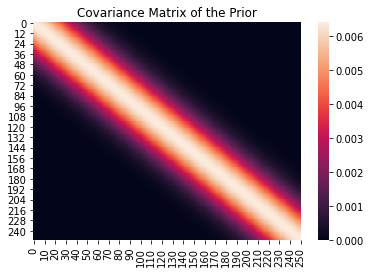

In [213]:
sns.heatmap(covmat).set_title('Covariance Matrix of the Prior')

A kernel (or covariance function) describes the covariance of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.

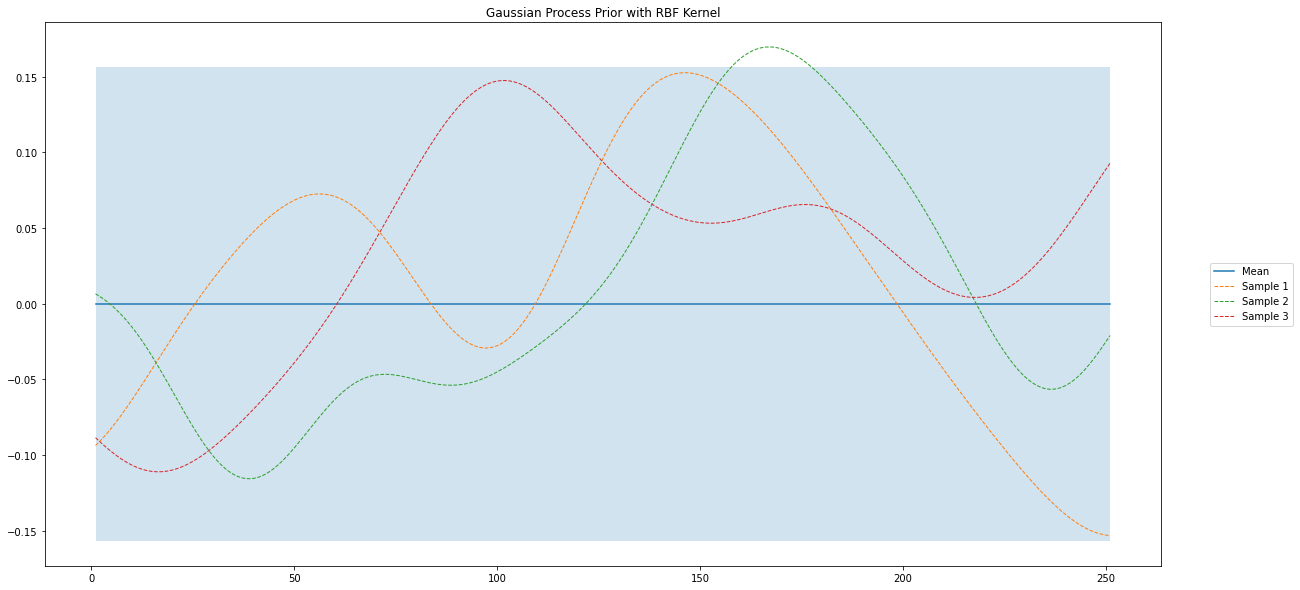

In [214]:
samples = np.random.multivariate_normal(mu.ravel(),covmat,3) #sampling 3 samples from the prior

plot_gps(mu, covmat, X, samples=samples)
plt.title('Gaussian Process Prior with RBF Kernel')
plt.show()

# **COVID-19 Cases - India**

1. **Posterior**

Here we arrive at a posterior by using Y as the observed data that modifies the mean function and variance and hence obtain a certain fit.

For the given noise value we arrive at this result where we are getting this posterior distribution which has been found out by hit and trials over a certain coarse steps for length and small steps for noise differing by 0.1.

Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

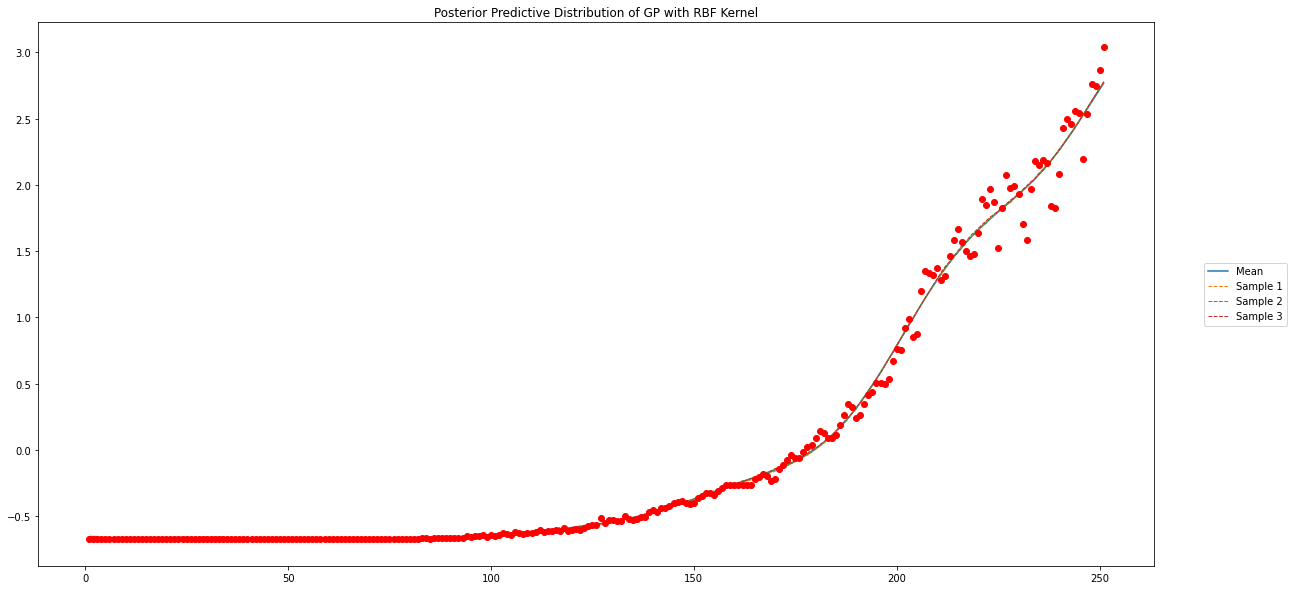

In [215]:
mu, covmat = sufficient_statistics(X, X_train, Y_train, l=27, s_f = 0.1, s_y=0.02, prior="rbf")

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

2. **Posterior Predective Distribution** 

Using the same values as above, we now introduce the value of X* (our test case) to arrive at our PPD using the sufficient statistics. Though, this model is not presenting the best fit or the best and optimized hyperparameters.

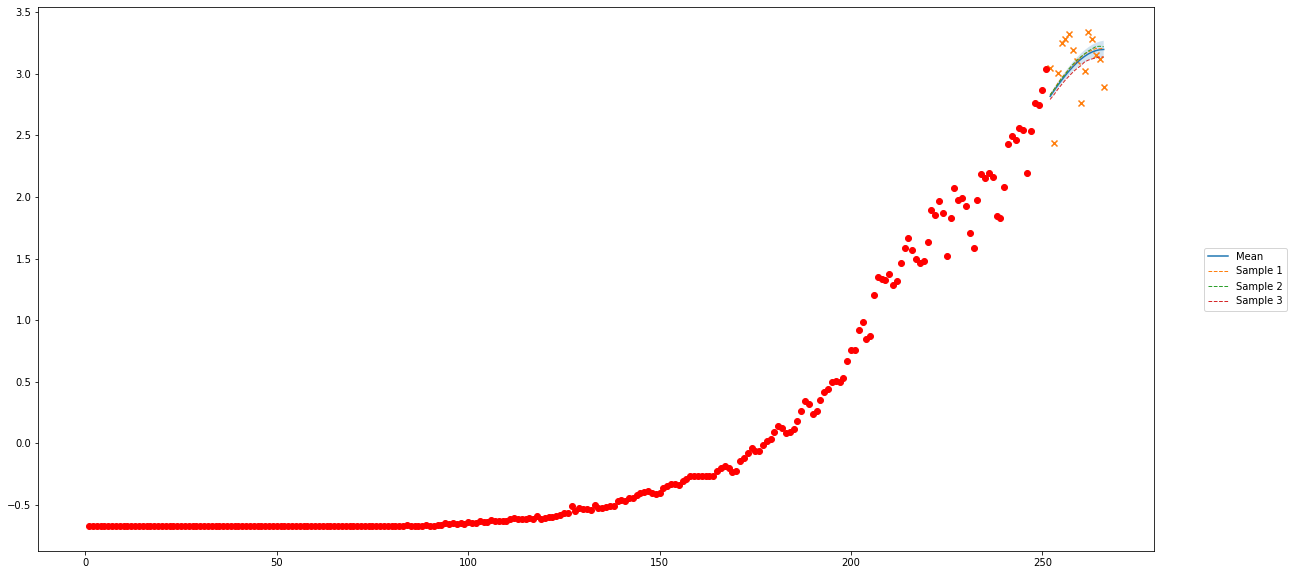

In [216]:
mu, covmat = sufficient_statistics(Xs, X_train, Y_train, l=27, s_f = 0.1, s_y=0.02, prior="rbf")
gt = np.array(y_test_i).reshape(-1,1)

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, Xs, X_train=X_train, Y_train=Y_train, gt=gt, samples=samples)

3. **Hyper-Parameter Optimization**

Here we use the function defined above for hyperparameter tuning for a certain value of noise to obtain point estimates of the parameters sigma_kernel and length as sf_hat and l_hat and plot the best fits for both the train and predicted mu for test data of 15 days.

Noise =  0.785
Best Fit Length = 81.02158234667877 and Best Fit Sigma of Kernel = 1.6524070279580054


Text(0.5, 1.0, 'Gaussian Process Posterior with RBF Kernel, best-fitting hyperparameters')

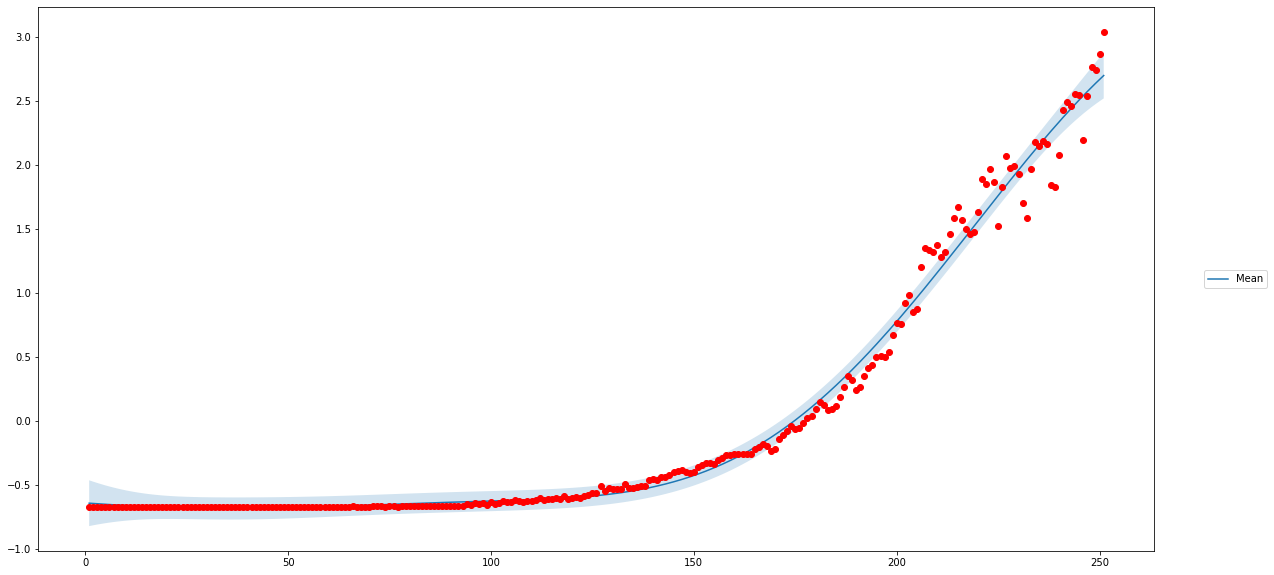

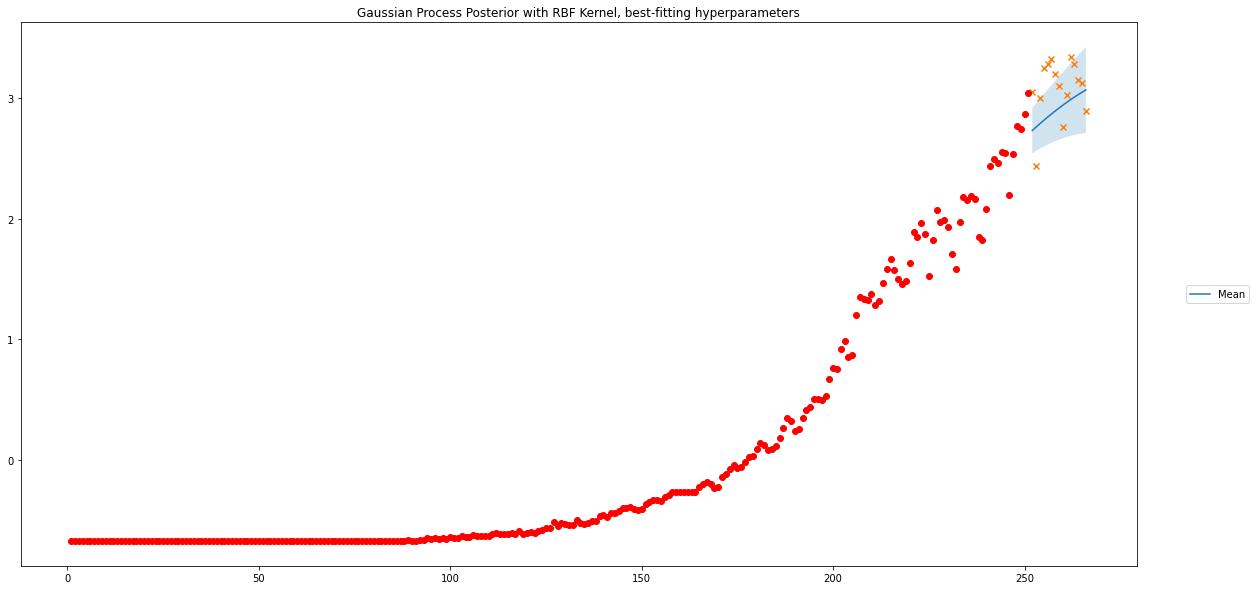

In [217]:
res = minimize(objective_function(X_train, Y_train, 0.3), [1, 1], bounds=((1e-5, None), (1e-5, None)), method='L-BFGS-B')

l_hat, s_f_hat = res.x

print("Noise = ", noise)
print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, s_f_hat))

m, K = sufficient_statistics(X, X_train, Y_train, l=l_hat, s_f=s_f_hat, s_y=0.3)

m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, s_f=s_f_hat, s_y=0.3)

plot_gps(m, K, X_train, X_train=X_train, Y_train=Y_train)
plot_gps(m_s, K_s, Xs, X_train=X_train, Y_train=Y_train, gt=gt)

plt.title('Gaussian Process Posterior with RBF Kernel, best-fitting hyperparameters')

# **For World Data**

1. **Posterior**

Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

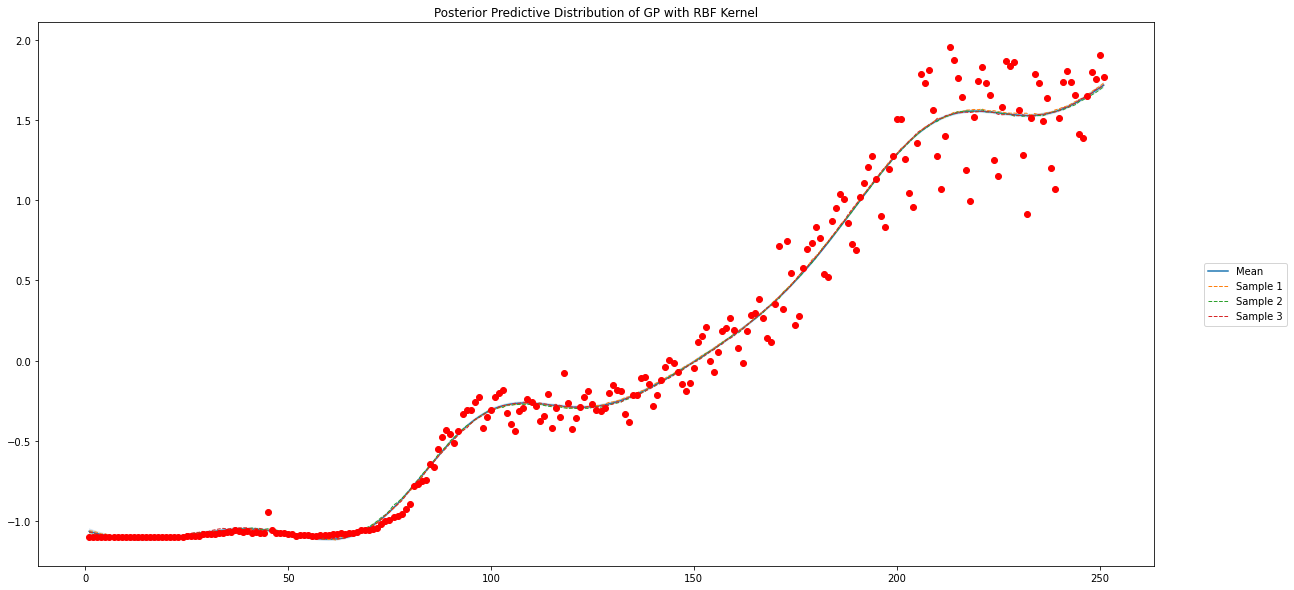

In [218]:
Y_train = np.array(y_train_w).reshape(-1, 1)

mu, covmat = sufficient_statistics(X, X_train, Y_train, l=27, s_f = 0.1, s_y=0.02, prior="rbf")

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

2. **Posterior Predective Distribution** 

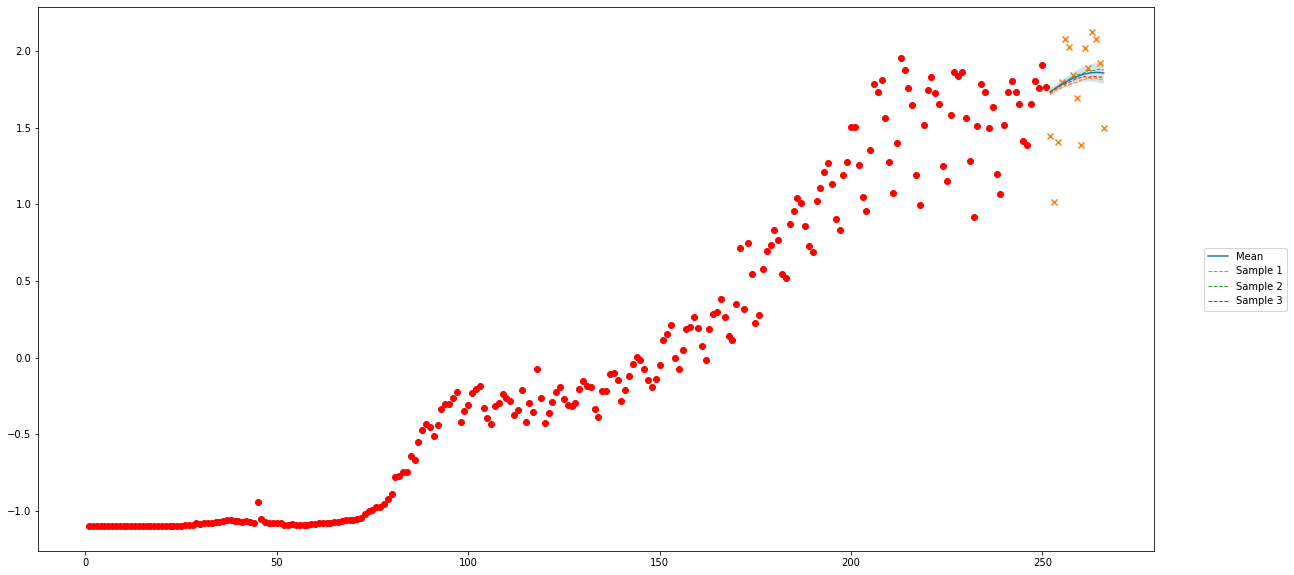

In [219]:
mu, covmat = sufficient_statistics(Xs, X_train, Y_train, l=27, s_f = 0.1, s_y=0.02, prior="rbf")
gt = np.array(y_test_w).reshape(-1,1)

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, Xs, X_train=X_train, Y_train=Y_train, gt=gt, samples=samples)

3. **Hyper-Parameter Optimization**

Noise =  0.785
Best Fit Length = 68.11985242431143 and Best Fit Sigma of Kernel = 0.980104899860455


Text(0.5, 1.0, 'GP Posterior with RBF Kernel, best-fitting hyperparameters')

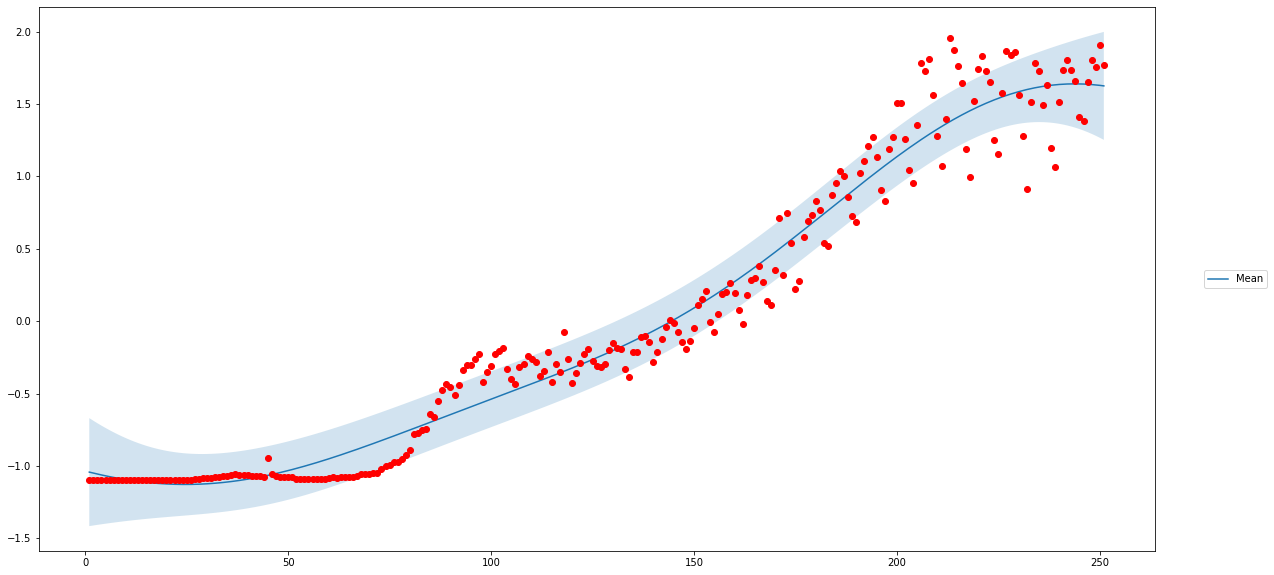

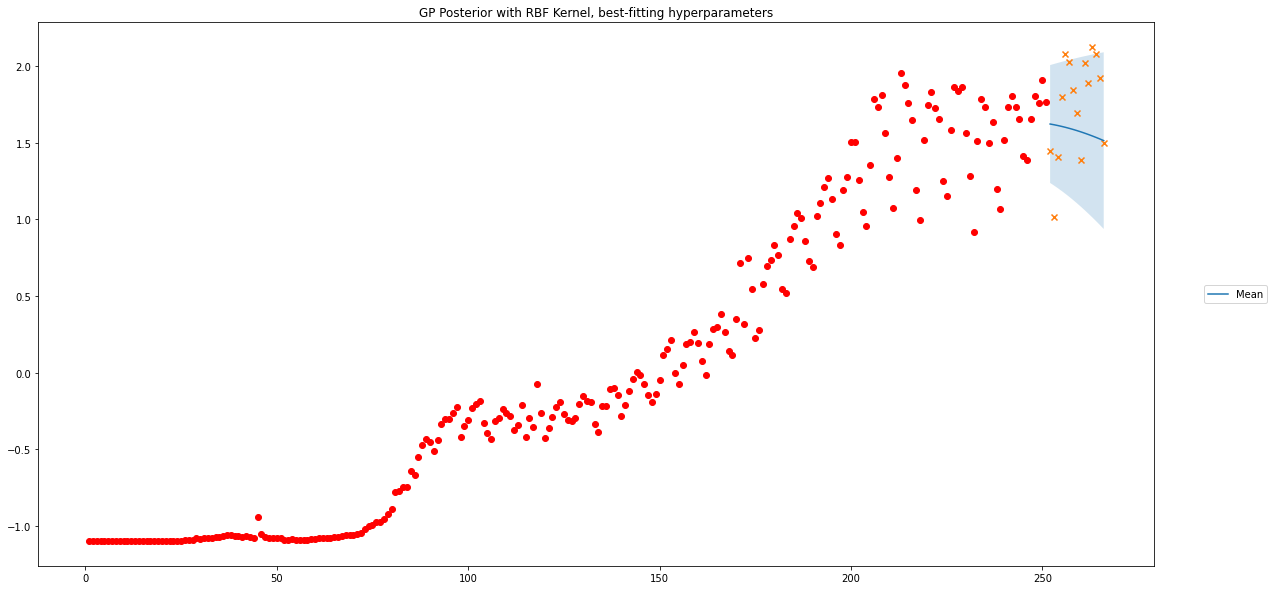

In [220]:
noise = 0.785

res = minimize(objective_function(X_train, Y_train, noise), [1, 1], bounds=((1e-8, None), (1e-8, None)), method='L-BFGS-B')

l_hat, s_f_hat = res.x

print("Noise = ", noise)
print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, s_f_hat))

m, K = sufficient_statistics(X, X_train, Y_train, l=l_hat, s_f=s_f_hat, s_y=noise)

m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, s_f=s_f_hat, s_y=noise)

plot_gps(m, K, X_train, X_train=X_train, Y_train=Y_train)
plot_gps(m_s, K_s, Xs, X_train=X_train, Y_train=Y_train, gt=gt)

plt.title('GP Posterior with RBF Kernel, best-fitting hyperparameters')